# Access FVCOM model output from THREDDs Server

This notebook is based on the notebook from Rich Signell USGS available [here](https://nbviewer.org/github/rsignell-usgs/ipython-notebooks/blob/master/files/FVCOM_depth_and_velocity.ipynb) and Tristan Salles [here](https://tristansalles.github.io/Coast/queryocean/oceanforecast.html).

intro text here

In [1]:
%matplotlib inline
from pylab import *
import numpy as np
import matplotlib.tri as Tri
import matplotlib.pyplot as plt
import netCDF4
import datetime as dt
import pandas as pd
from io import StringIO


%config InlineBackend.figure_format = 'png'
plt.rcParams['mathtext.fontset'] = 'cm'

import warnings
warnings.filterwarnings('ignore')

## Loading the model dataset

explanatory text here

In [2]:
# Set the URL
url = 'https://www.ncei.noaa.gov/thredds/dodsC/model-lmhofs-files/2022/10/nos.lmhofs.fields.n001.20221017.t18z.nc'

# Load it via OPeNDAP
nc = netCDF4.Dataset(url)

# Query the variables
nc.variables.keys()

odict_keys(['nprocs', 'partition', 'x', 'y', 'lon', 'lat', 'xc', 'yc', 'lonc', 'latc', 'siglay', 'siglev', 'h', 'nv', 'iint', 'time', 'Itime', 'Itime2', 'Times', 'zeta', 'nbe', 'ntsn', 'nbsn', 'ntve', 'nbve', 'a1u', 'a2u', 'aw0', 'awx', 'awy', 'art2', 'art1', 'u', 'v', 'tauc', 'omega', 'ww', 'temp', 'salinity', 'viscofm', 'viscofh', 'km', 'kh', 'kq', 'q2', 'q2l', 'l', 'short_wave', 'net_heat_flux', 'uwind_speed', 'vwind_speed', 'atmos_press', 'wet_nodes', 'wet_cells', 'wet_nodes_prev_int', 'wet_cells_prev_int', 'wet_cells_prev_ext'])

In [3]:
# take a look at the "metadata" for the variable "u"
print (nc.variables['u'])

<class 'netCDF4._netCDF4.Variable'>
float32 u(time, siglay, nele)
    long_name: Eastward Water Velocity
    standard_name: eastward_sea_water_velocity
    units: meters s-1
    grid: fvcom_grid
    type: data
    coordinates: time siglay latc lonc
    mesh: fvcom_mesh
    location: face
unlimited dimensions: time
current shape = (1, 20, 171377)
filling off



## Set FVCOM simulation time

In [4]:
# Desired time for snapshot
# ....right now (or some number of hours from now) ...
# start = dt.datetime.utcnow() + dt.timedelta(hours=6)

# ... or specific time (UTC)
start = dt.datetime(2022,10,17,18,0,0)

In [5]:
# Get desired time step  
time_var = nc.variables['time']
itime = netCDF4.date2index(start,time_var,select='nearest') 
print(itime, start)

0 2022-10-17 18:00:00


In [6]:
dtime = netCDF4.num2date(time_var[itime],time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
print(daystr)

2022-Oct-17 12:59


## Get specific data from FVCOM outputs

In [7]:
# Get lon,lat coordinates for nodes (depth)
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
# Get lon,lat coordinates for cell centers (depth)
latc = nc.variables['latc'][:]
lonc = nc.variables['lonc'][:]
# Get Connectivity array
nv = nc.variables['nv'][:].T - 1 
# Get depth
h = nc.variables['h'][:]  # depth

In [8]:
# Take FVCOM Delaunay grid
tri = Tri.Triangulation(lon,lat,triangles=nv)

## Find FVCOM velocity field

In [9]:
# Get current at layer [0 = surface, -1 = bottom]
ilayer = 0
u = nc.variables['u'][itime, ilayer, :]
v = nc.variables['v'][itime, ilayer, :]

## Visualize FVCOM forecast model

In [10]:
print(np.min(latc), np.max(latc))
print(np.min(lonc), np.max(lonc))

41.622066 46.348766
271.9592 280.2832


In [11]:
# Region to plot
# ax= [-72, -69, 40, 43.5] 
# ax = [np.min(lonc), np.max(lonc), np.min(latc), np.max(latc)]
ax = [271.5, 275, np.min(latc), np.max(latc)]

# Find velocity points in bounding box
ind = np.argwhere((lonc >= ax[0]) & (lonc <= ax[1]) & (latc >= ax[2]) & (latc <= ax[3]))

In [12]:
# Depth contours to plot
# levels=np.arange(-200,2,1)   
levels=np.arange(-281,10,1)   

In [13]:
subsample = 3
np.random.shuffle(ind)
Nvec = int(len(ind) / subsample)
idv = ind[:Nvec]

## Plot in iPython

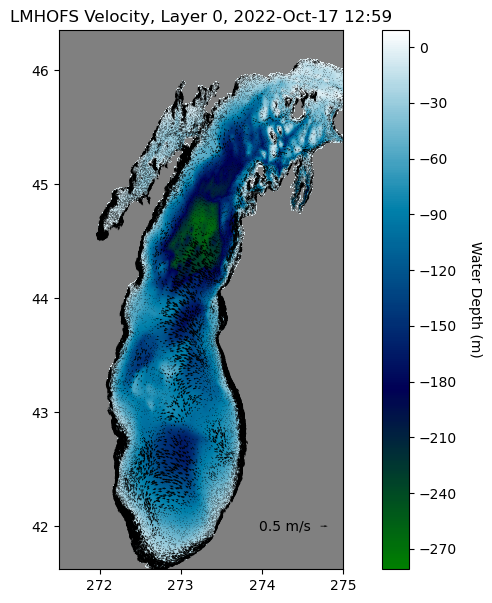

In [14]:
# tricontourf plot of water depth with vectors on top
fig1 = plt.figure(figsize=(10,7))

ax1 = fig1.add_subplot(aspect=(1.0/np.cos(np.mean(lat)*np.pi/180.0)))

# Water depth
plt.tricontourf(tri, -h, levels=levels, cmap=plt.cm.ocean)
plt.axis(ax)

ax1.patch.set_facecolor('0.5')
cbar=plt.colorbar()
cbar.set_label('Water Depth (m)', rotation=-90, labelpad=18)

# Quiver plot
Q = ax1.quiver(lonc[idv],latc[idv],u[idv],v[idv],scale=20)
qk = plt.quiverkey(Q,0.92,0.08,0.50,'0.5 m/s',labelpos='W')

plt.title('LMHOFS Velocity, Layer %d, %s' % (ilayer, daystr))
plt.show()

## Extract water levels, analyze & visualize

In [15]:
# Enter desired (Station, Lat, Lon) values here:
x = '''
Station, Lat, Lon
Milwaukee WI,   43.027830, -87.862389
Grand Haven MI, 43.059010, -86.268869
Midlake,   43.908558, -87.037931
'''
# Create a Pandas DataFrame
obs=pd.read_csv(StringIO(x.strip()), sep=",\s*",index_col='Station',engine='python')
# Convert longitude coordinate
obs['Lon'] = 360.0 + obs['Lon']
obs

,Lat,Lon
Station,,
Milwaukee WI,43.027830,272.137611
Grand Haven MI,43.059010,273.731131
Midlake,43.908558,272.962069


In [16]:
#LMHOFS nowcast model
model='LMHOFS'
url='https://www.ncei.noaa.gov/thredds/dodsC/model-lmhofs-files/2022/10/nos.lmhofs.fields.n001.20221017.t18z.nc'

# Open NECOFS remote OPeNDAP dataset 
nc2=netCDF4.Dataset(url).variables

In [17]:
# Find the indices of the points in (x,y) closest to the points in (xi,yi)
def nearxy(x,y,xi,yi):
    
    ind=np.ones(len(xi),dtype=int)
    for i in np.arange(len(xi)):
        dist=np.sqrt((x-xi[i])**2+(y-yi[i])**2)
        ind[i]=dist.argmin()
        
    return ind

In [18]:
# Query to find closest NECOFS nodes to station locations
obs['NODE-ID'] = nearxy(nc2['lon'][:],nc2['lat'][:],obs['Lon'],obs['Lat'])
obs

,Lat,Lon,NODE-ID
Station,,,
Milwaukee WI,43.027830,272.137611,15378
Grand Haven MI,43.059010,273.731131,13917
Midlake,43.908558,272.962069,26788


In [19]:
# Get time values and convert to datetime objects
times = nc2['time']
jd = netCDF4.num2date(times[:],times.units)

# Get all time steps of water level from each station
nsta=len(obs)
z=np.ones((len(jd),nsta))
for i in range(nsta):
    z[:,i] = nc2['zeta'][:,obs['NODE-ID'][i]]
    
# Make a DataFrame out of the interpolated time series at each location
zvals=pd.DataFrame(z,index=jd,columns=obs.index)

# List out a few values
zvals.head(4)

Station,Milwaukee WI,Grand Haven MI,Midlake
2022-10-17 12:59:56.484375,0.580812,0.640697,0.57948


In [ ]:
# Plotting the DataFrame
ax=zvals.plot(figsize=(18,4),grid=True,
              title=('LMHOFS Nowcast Water Level from %s Forecast' % model),
              legend=False,linewidth=2)

# Read units from dataset for ylabel
plt.ylabel(nc2['zeta'].units)

# Plotting the legend outside the axis is a bit tricky
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.55, box.height])
setp(gca().get_xticklabels(), rotation=45, horizontalalignment='right')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));